In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

unwanted_columns = ['HomePlanet', 'CryoSleep', 'Destination','VIP','Cabin_deck','Cabin_starboard','Passenger_group']

# Function to Scale the data and Prepare Trainning and Test data
def get_data_for_trainning(df,test_size=0.2):
  scaler = StandardScaler()
  X = df.drop(columns=['Transported'])
  y = df['Transported']
  df_scaled = scaler.fit_transform(X)
  df_scaled = pd.DataFrame(df_scaled,columns=X.columns,index=X.index)
  X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test,scaler

#Function to Test the Models
def train_models(X_train,X_test,y_train,y_test):
  models = {
      'Logistic Regression': LogisticRegression(),
      'Naive Bayes': GaussianNB(),
      'Support Vector Machine': SVC(),
      'K-Nearest Neighbors': KNeighborsClassifier(),
      'Decision Tree': DecisionTreeClassifier(),
      'Random Forest': RandomForestClassifier(random_state=42),
      'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
  }


  metrics_df = pd.DataFrame(columns=['Model', 'Accuracy'])
  trained_models = {}
  classification_reports = {}


  for name, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      report = classification_report(y_test, y_pred)
      classification_reports[name] = report
      trained_models[name] = model
      new_row = pd.DataFrame({'Model': [name], 'Accuracy': [accuracy]})
      metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

      # print(f'Model: {name}')
      # print(f'Accuracy: {accuracy}\n')

  return trained_models,metrics_df, classification_reports

#Function to Plot the Confusion Matrix
def plot_confusion_matrix(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Plot confusion matrix as heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(model, X_test, y_test):
    # Plot ROC curve
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def print_classification_report(y_test, y_pred):
    print("Classification Report:\n", classification_report(y_test, y_pred))

def generate_predictions(model,df,scaler,label_encoder):
  x = df.drop(columns=['PassengerId'])
  x_scaled = scaler.transform(x)
  x = pd.DataFrame(x_scaled,columns=x.columns,index=x.index)
  preds = model.predict(x)
  df['Transported'] = label_encoder.inverse_transform(preds)
  return df

### Hyperparamer tuning

In [ ]:
feat_df = pd.read_csv('feat_df_train.csv')
feat_df_test = pd.read_csv('feat_df_test.csv')

xgboost = xgb.XGBClassifier()
xgboost.load_model('xgboost_model.json')

In [ ]:
from sklearn.model_selection import GridSearchCV
#function for hyper parametr tuning
def hyper_parameter_tuning(xgboost_model,X_train, X_test, y_train, y_test):
  param_grid = {
      'n_estimators': [50, 100, 200],
      'learning_rate': [0.01, 0.1, 0.2],
      'max_depth': [3, 4, 5],
  }
  grid_search = GridSearchCV(xgboost_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1,verbose=10)
  grid_search.fit(X_train, y_train)
  best_params = grid_search.best_params_
  print (f"Best Params Found: {best_params}")
  best_estimator = grid_search.best_estimator_
  y_pred = best_estimator.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return best_estimator

In [ ]:
df = feat_df.drop(columns=unwanted_columns)
X_train, X_test, y_train, y_test,scaler_with_fe = get_data_for_trainning(df,test_size=0.2)
best_xgboost = hyper_parameter_tuning(xgboost,X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params Found: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [ ]:
df = feat_df_test.drop(columns=unwanted_columns)
df = generate_predictions(best_xgboost,df,scaler_with_fe,label_encoder)
df[['PassengerId','Transported']].to_csv('preds3.csv',index=False)

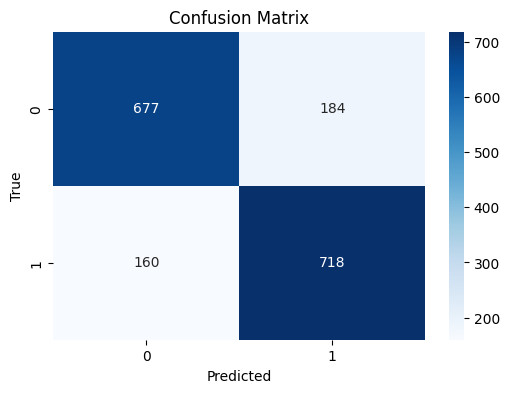

In [ ]:
plot_confusion_matrix(best_xgboost, X_test, y_test)

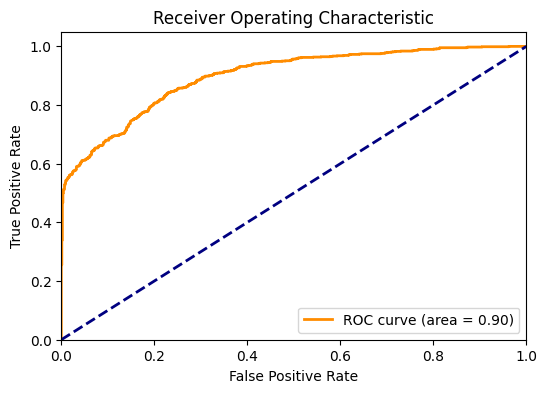

In [ ]:
plot_roc_curve(best_xgboost, X_test, y_test)

In [ ]:
y_pred = best_xgboost.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       861
           1       0.80      0.82      0.81       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



### Model Interpretability

In [ ]:
import matplotlib.pyplot as plt
import shap

def plot_feature_importance(model, feature_names):
    """
    Plots feature importance for tree-based models.
    """

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Only select the top 10 features
    top_indices = indices[:10]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]
    plt.figure(figsize=(10, 5))
    plt.barh(range(len(top_names)), top_importances, align='center')
    plt.yticks(range(len(top_names)), top_names)
    plt.xlabel('Feature Importance')
    plt.title("Top 10 Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

def plot_shap_values(model, X_train):
    """
    Plots SHAP values for model interpretability.
    """
    # Explain model's predictions using SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)

    # Plot SHAP values
    shap.plots.beeswarm(shap_values)



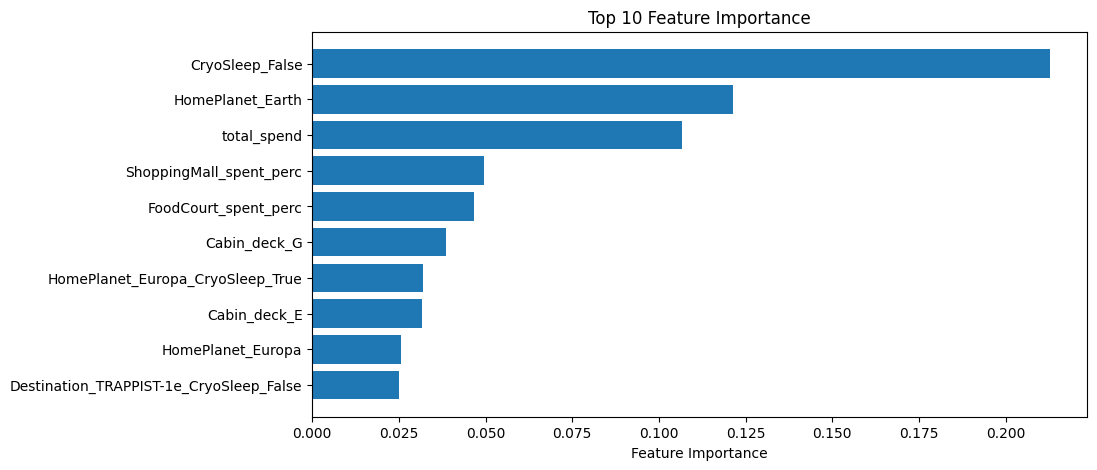

In [ ]:
plot_feature_importance(model=best_xgboost, feature_names=X_train.columns)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


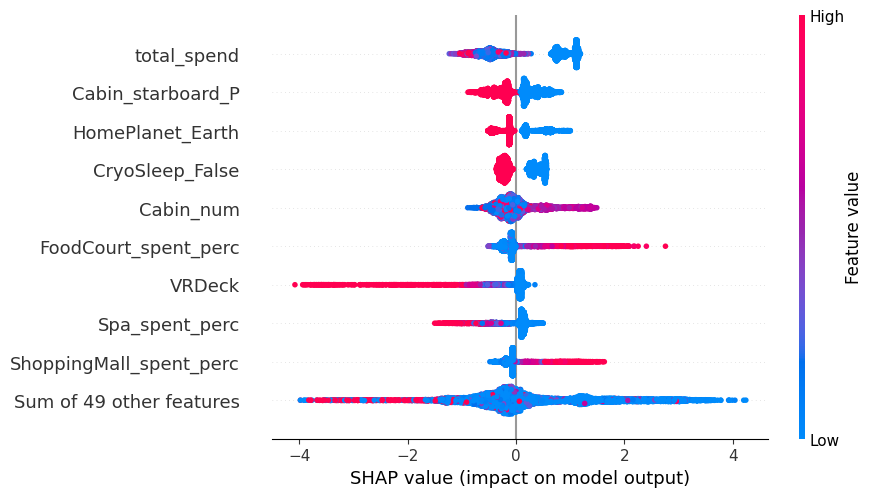

In [ ]:
plot_shap_values(model=best_xgboost, X_train=X_train)